# Project 1: Sex Differences in brain organization

### Main Script: Microsctructure

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
import pingouin as pg
import pickle

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'

## Import functions

In [3]:
%run p1_myfunctions.ipynb

# Data 

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [4]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


In [ ]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [ ]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [ ]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [ ]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html -> requires data to be in fsaverage surface (not feasible with Schaefer parcellation)

**NOTE: schaefer_400_fs5 == 0 corresponds to midline (labels go from 0-400) -> disregard 0 in calculations and plotting**

In [ ]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

## Descriptive HCP

### Retrieving the cleaned demographics dataframe (ready for analysis)

In [10]:
HCP_demographics_cleaned = pd.read_csv(resdir_hcp+'demographics_cleaned.csv')

In [11]:
HCP_demographics_cleaned

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used,Unnamed: 201,Unnamed: 202,Unnamed: 203,TwinStatus,TwinStatus_num,Family_ID_num,global_ct
0,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,118,2.583466
1,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,0.0,2.0,1.0,NaN,NaN,NaN,MZ,0,151,2.682427
2,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,1.0,2.0,4.0,NaN,NaN,NaN,MZ,0,39,2.534514
3,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,DZ,1,8,2.623609
4,101006,S500,Q06,F,31-35,True,2,2,4,100.0,...,0.0,2.0,5.0,NaN,NaN,NaN,MZ,0,1,2.542655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,992673,S900,Q12,F,31-35,True,1,2,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,346,2.582893
1010,992774,Q2,Q02,M,31-35,True,2,2,4,100.0,...,0.0,3.0,2.0,NaN,NaN,NaN,sibling,2,277,2.616927
1011,993675,S900,Q09,F,26-30,True,2,2,4,100.0,...,0.0,NaN,0.0,NaN,NaN,NaN,sibling,2,347,2.635552
1012,994273,S500,Q06,M,26-30,True,1,1,4,100.0,...,1.0,2.0,5.0,NaN,NaN,NaN,sibling,2,202,2.677629


## Microstructural data 

MPC-fc-schaefer400.mat file taken from /data/pt_02319/schaare/data/HCP_fromSofie/ - contains connectivity matrices for:

- MPCnx : 1206, 400, 400  # MPC
- matrix_hcp400z : 1206, 400, 400  # fc z-scored
### **! CHECK WITH SOFIE !**


In [12]:
scipy.io.whosmat(datadir + 'HCP_microstructure/MPC-fc-schaefer400.mat')

[('MPCnx', (1206, 400, 400), 'double'),
 ('matrix_hcp400z', (1206, 400, 400), 'double')]

In [69]:
# taking the MPC matrices from the mat file
MPC_matrices = scipy.io.loadmat(datadir + 'HCP_microstructure/MPC-fc-schaefer400.mat')['MPCnx']

In [70]:
MPC_matrices.shape

(1206, 400, 400)

In [71]:
mean_MPC_matrix = sum(MPC_matrices)/len(MPC_matrices)

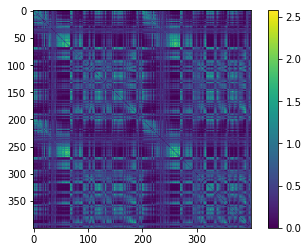

In [72]:
plt.imshow(mean_MPC_matrix)
plt.colorbar()
plt.show()

### Remove subjects with missing fc matrices from structural analysis so that sample is the same across analyses

#### Retrieving one of the original (restricted) demographics dataframe because we need it to be able to index out (from MPC matrices) subjects who have FC matrices

In [16]:
restricted_data = pd.read_csv(datadir+'RESTRICTED_wanb_9_29_2020_2_14_36.csv')
print(f'Total Sample: N = {len(restricted_data)}')

Total Sample: N = 1206


#### Retrieving list of subjects (obtained from functional data -> subjects who have FC matrices)

In [17]:
HCP_sub_list = pd.read_csv(datadir+'HCP_sub_list.csv', header = None)[0].to_list()
HCP_sub_list = [str(e) for e in HCP_sub_list]  # making every subject ID number in the list a string in order to match the format of the variable HCP_sub_list as it was originally yielded when retrieving FC matrices

In [18]:
len(HCP_sub_list)

1014

#### Getting a subsample of MPC matrices that matches 1014 sample that has FC matrices

In [73]:
### identifying which subjects have missing fc matrices (their indices, given that subject order is preserved across demographics, FC data, CT data)

# creating a list -> indices to be removed in structural data
indices_missing_fc = []

# to keep track of current iteration number (will be used as reference of index for subjects with missing fc matrices)
count_index = 0  

# iterating over all 1206 subjects (original sample)
for subID in restricted_data.loc[:,'Subject']:
    
    # if subject ID from the original sample is not in the HCP_sub_list (containing the subject IDs of subjects who have fc matrices), then add the current location of the subject ID in list (index) to the indices_missing_fc list
    if str(subID) not in HCP_sub_list:
        indices_missing_fc.append(count_index)
    
    # increment the index count (only at the end of loop so that first index = 0 and can actually be used as an index
    count_index += 1

### remove subjects (via their indices) who do not have fc matrices
MPC_matrices = np.delete(MPC_matrices, indices_missing_fc, axis=0)

In [74]:
MPC_matrices.shape

(1014, 400, 400)

#### check that there are no NaNs

In [96]:
np.argwhere(np.isnan(MPC_matrices))

array([], shape=(0, 3), dtype=int64)

# Computing MPC gradients

## Mean gradients

*Needed for figures and for computing aligned gradients*

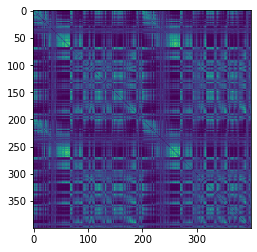

(400, 400)


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


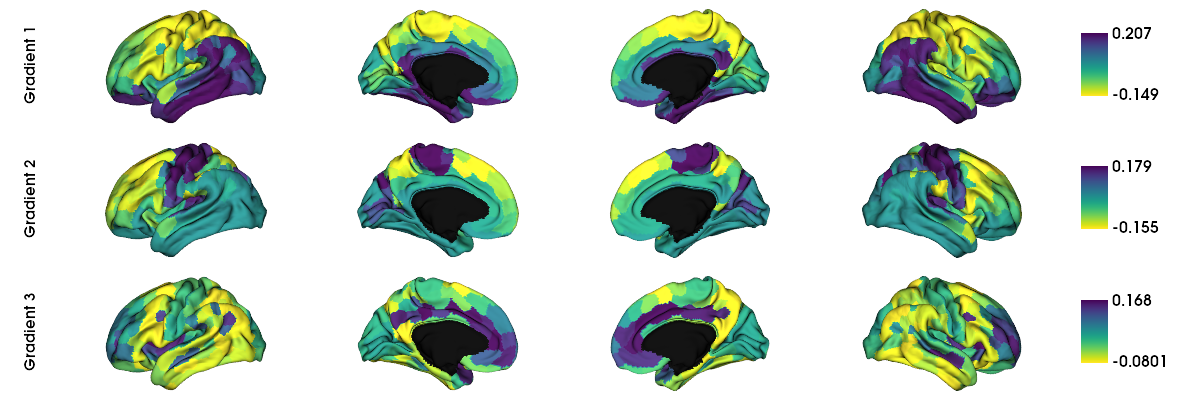

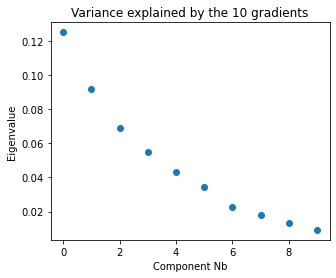

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.48

Scaled variance explained by individual gradients:
G1: 25.95%
G2: 19.07%
G3: 14.36%



In [78]:
# compute the mean MPC matrix (by averaging the connectivity matrices of all subjects)
HCP_mean_mpc_matrix = sum(MPC_matrices)/len(MPC_matrices)

# compute mean gradients
HCP_mean_mpc_grad = compute_mean_gradients(mean_conn_matrix = HCP_mean_mpc_matrix, display_output = True, data_reduction_algorithm = 'dm', save_screenshot = False, sample_modality = 'HCP_mpc')

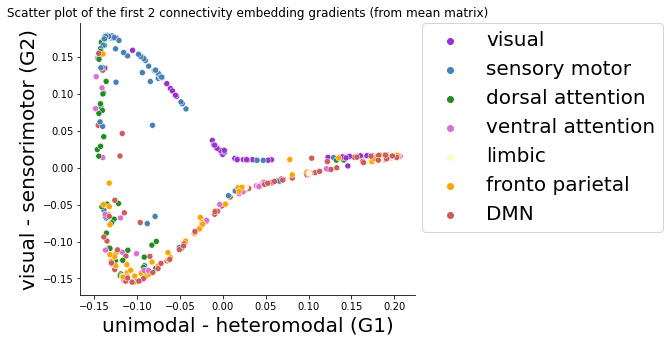

In [79]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=HCP_mean_mpc_grad.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=HCP_mean_mpc_grad.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)', fontsize = 20);
ax.set_ylabel('visual - sensorimotor (G2)', fontsize = 20);
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')

ax.legend(fontsize=20, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
#ax.legend(loc=2, prop={'size': 6})

plt.show(ax)

### Export mean_mpc_matrix for structure-function analyses

In [81]:
# all subjects
np.savetxt(resdir_hcp+'HCP_mean_mpc_matrix.csv', HCP_mean_mpc_matrix, delimiter=",")

## Aligned gradients

Construct gradients for all subjects (procrustes alignment to the overall mean matrix)

In [87]:
MPC_matrices.shape

(1014, 400, 400)

In [85]:
HCP_mean_mpc_grad.gradients_.shape

(400, 10)

# Resume here 
https://stackoverflow.com/questions/21827594/raise-linalgerrorsvd-did-not-converge-linalgerror-svd-did-not-converge-in-m
If there are no inf or NaN values, possibly that is a memory issue. Please try in a machine with higher RAM.

In [93]:
HCP_compute_aligned_grad = compute_aligned_gradients(MPC_matrices, HCP_mean_mpc_grad.gradients_)

# storing the output of the computation of the aligned gradients
#HCP_array_aligned_gradients = HCP_compute_aligned_grad['array_aligned_gradients']
HCP_array_aligned_mpc_G1 = HCP_compute_aligned_grad['array_aligned_G1']
HCP_array_aligned_mpc_G2 = HCP_compute_aligned_grad['array_aligned_G2']
HCP_array_aligned_mpc_G3 = HCP_compute_aligned_grad['array_aligned_G3']

LinAlgError: SVD did not converge

### Exporting Gradients to csv for R analyses

In [37]:
# fmt = decimals, header = 1 to 400 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir_hcp+'array_aligned_mpc_G1.csv', HCP_array_aligned_mpc_G1, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_mpc_G2.csv', HCP_array_aligned_mpc_G2, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_mpc_G3.csv', HCP_array_aligned_mpc_G3, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')